<a href="https://colab.research.google.com/github/robert-lemon-uhm/Presidential-Tweets-Markov-Models/blob/main/Second_Order_Markov_Character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Second Order Character Markov Model Code

In [ ]:
# Download tweets.
import numpy as np
import random
import pickle
import cloudpickle as cp
from urllib.request import urlopen
lst_donald_trump_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/DonaldTrumpTweets.pickle"))
lst_joe_biden_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/JoeBidenTweets.pickle"))

**MODEL NOTES**

*   This model has a token vocabulary of 27 printable characters and 3 sentinal characters.

*   The 'Fit' method initializes the internal transition matrix to all 1s, updates the count as it processes the data set, then normalizes each row so the row's probabilities sum to 1.  Before the normalization, rows or columns with impossible values (i.e., transitioning *to* a start token) were zeroed out.  This was done to ensure the closest possible probabilities for the rest of the transitions.



In [ ]:
class char_ngram():
  def __init__(self):
    '''Initialize vocabulary and parameters of model.'''
    # Special tokens: ^==start, $==stop.
    self.tokens = '*^$ abcdefghijklmnopqrstuvwxyz'
    # Create map from token to index (integer).
    self.token_idx = dict([(t,i) for (i,t) in enumerate(self.tokens)]) 
    # Initialize matrix of transition probabilities to uniform distribution.
    self.n = len(self.tokens)
    self.transitions = np.ones((self.n,self.n,self.n), dtype='float')
    return

  def fit(self, data):
    '''
    Learn transition probabilities from data.
    Input:
        data = list of strings to train on.
    Output:
        none
    '''
    # Re-initialize matrix
    self.transitions = np.ones((self.n,self.n,self.n), dtype='float')
    # Build transitons matrix
    for string in data:
      # Check for empty string
      if string is None:
        raise Exception("Empty tweets are not allowed! Did not finish fitting")
      tokenString = self.tokenize(string)
      i = 0
      # Process string
      while (tokenString[i+1] != '$'):
        x1 = self.token_idx[tokenString[i]]
        x2 = self.token_idx[tokenString[i+1]]
        x3 = self.token_idx[tokenString[i+2]]
        self.transitions[x1, x2, x3] += 1
        i += 1
    # Clean up matrix
    self.transitions[:,:,self.token_idx['*']] = 0 # never transition to '*'
    self.transitions[:,:,self.token_idx['^']] = 0 # never transition to '^'
    self.transitions[self.token_idx['$'],:,:] = 0 # never transition after '$'
    self.transitions[:,self.token_idx['$'],:] = 0 # never transition after '$'
    self.transitions[:,self.token_idx['^'],self.token_idx['$']] = 0 # no empty tweets
    # Normalize matrix
    for i in range(self.n):
      for j in range(self.n):
        rowSum = sum(self.transitions[i,j,:])
        if rowSum != 0:
          self.transitions[i,j,:] /= rowSum
    return

  def generate(self, prompt=None):
    '''
    Generate a random string of length N starting from prompt.
      Input:
        prompt (optional): a string that should begin the tweet, e.g. 'covid'. 
    Returns:
        tweet = A fake tweet (string).
    '''
    # initialize tweet
    tweet = ['*', '^']
    length = 2
    # start tweet with prompt (optional)
    if (prompt):
      chars = list(prompt)
      chars = chars[:280]
      for ch in chars:
        tweet.append(ch)
        length += 1
    # generate remainder of tweet
    while (length < 282 and tweet[length - 1] != '$'):
      prev1 = self.token_idx[tweet[length - 2]]
      prev2 = self.token_idx[tweet[length - 1]]
      nextCh = self.randCatSample(self.transitions[prev1,prev2,:])
      tweet.append(self.tokens[nextCh])
      length += 1
    # remove start and stop tokens from new tweet
    if (tweet[length - 1] == '$'):
      tweet.remove('$')
      length -= 1
    tweet.remove('*')
    tweet.remove('^')
    length -= 2
    # return tweet as string
    return ''.join(tweet)

  @staticmethod
  def randCatSample(probs):
    '''
    A simple utility function that randomly 
    samples from a categorical distribution
    Input:
        array of probabilities
    Output:
        index of random sample
    '''
    # sample from a categorical random dist
    rand = random.random()
    sum = 0
    for i in range(len(probs)):
      sum += probs[i]
      if (sum > rand):
        return i

  def tokenize(self, string):
    '''
    A simple character tokenization:
    1) Leading and ending spaces are removed.
    2) All letters converted to lowercase.
    3) All characters other than a-z and space are ignored.
    Input:
        string
    Returns: 
        tokens = list of characters (python strings of length 1).
    '''
    tokens = []
    sanitized = string.lower().strip().replace('^','').replace('$','').replace('*','')
    for char in sanitized:
      if char in self.tokens:
        tokens.append(char)
    # Add start and stop tokens.
    tokens = ['*', '^'] + tokens + ['$']
    return tokens

  def evaluate(self, data):
    '''
    Calculate the mean log probability of the character transitions.
    We use mean because then we have a fair comparison between two sequences
    of different lengths.
    Input:
        data = string or list of strings to train on.
    Returns:
        mean_logp = (float) average of the log2 probability of the transitions in the data.
    '''
    if type(data) is str:
      data = [data] # Interpret as list of length 1.
    logp_sum = 0
    count = 0
    for string in data:
      s = self.tokenize(string)
      for i in range(2, len(s)):
        c1 = self.token_idx[s[i-2]]
        c2 = self.token_idx[s[i-1]]
        c3 = self.token_idx[s[i]]
        p = self.transitions[c1,c2,c3]
        if p == 0:
          raise Exception('The model thinks this sequence is impossible'
                          '! Regularize the transition probabilities.')
        logp_sum += np.log2(p) 
        count += 1
    mean_logp = logp_sum / count
    return mean_logp

  def tokenizedLen(self, string):
    '''
    Utility function to return the amount of valid
    characters in a string (minus start and stop)
    '''
    return len(self.tokenize(string)) - 3

## Part 1: Generating Random Tweets

The generated tweets from the second order charcter models were definitely better than the first order models.  The frequency of actual words has definitely increased, but the complexity of those words have not.  Unfortunately, no other patterns between generated tweets from the models trained on Trump versus Biden have emerged at the second order level.  The model's ability to accurately label tweets has improved though (see Part 2).

*Sample Tweets*

*   **TRUMP:**  rt covirus poswdpdong the ingethe le wi

*   **TRUMP:**  rt te to for willy trump whatrancgpfassaylews  a by ing

     =====

*   **BIDEN:**   dememonats nother anding tiong amp froursiden revereallown themin direges iters publicareemerwxc

*   **BIDEN:**  nue is oll amesingre everess ald how ht to matent fre an upme noway thelp navelimicare mareve unight cesiskwee wil pefurettpsts al orke promeross ot roursto thisidernxfly giveries of  htteris wor we lethe orking them in re is of whon the placreford al a of zybodayeadsrome oure pe

In [ ]:
# Train models on full dataset
TRUMP1 = char_ngram()
TRUMP1.fit(lst_donald_trump_tweets)

BIDEN1 = char_ngram()
BIDEN1.fit(lst_joe_biden_tweets)

In [ ]:
# Generate and print random tweets
newTweetTrump = TRUMP1.generate("")
newTweetBiden = BIDEN1.generate("")
print("TRUMP: ", newTweetTrump)
print("BIDEN: ", newTweetBiden)

## Part 2: Evaluating Real Tweets

The second order markov character model has a 4% higher AUROC than the first order model, for an average AUROC of 98% (see ROC graph at the bottom). While this is a definite improvement, it still fell 0.5% short of the average AUROC of the first order word model.  These results were based off of around 2,000 training tweets per candidate, with around 1,000 held-out test tweets to evaluate the models on.

In [ ]:
import random
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Permute data
randomTrumpTweets = lst_donald_trump_tweets
randomBidenTweets = lst_joe_biden_tweets
random.shuffle(randomTrumpTweets)
random.shuffle(randomBidenTweets)

# Split data into training and testing sets
dataSplit = 0.66

trumpLen = int(len(randomTrumpTweets) * dataSplit)
trumpTrain = randomTrumpTweets[:trumpLen]
trumpTest = randomTrumpTweets[trumpLen:]

bidenLen = int(len(randomBidenTweets) * dataSplit)
bidenTrain = randomBidenTweets[:bidenLen]
bidenTest = randomBidenTweets[bidenLen:]

In [ ]:
# Train models on training sets
TRUMP2 = char_ngram()
TRUMP2.fit(trumpTrain)

BIDEN2 = char_ngram()
BIDEN2.fit(bidenTrain)

In [ ]:
# Evaluate Trump's tweets using both models
trumpTestTRUMP = np.zeros((len(trumpTest)), dtype=float)
trumpTestBIDEN = np.zeros((len(trumpTest)), dtype=float)
for i in range(len(trumpTest)):
  n = TRUMP2.tokenizedLen(trumpTest[i])
  trumpTestTRUMP[i] = TRUMP2.evaluate(trumpTest[i]) * n
  trumpTestBIDEN[i] = BIDEN2.evaluate(trumpTest[i]) * n

# Evaluate Biden's tweets using both models
bidenTestTRUMP = np.zeros((len(bidenTest)), dtype=float)
bidenTestBIDEN = np.zeros((len(bidenTest)), dtype=float)
for i in range(len(bidenTest)):
  n = BIDEN2.tokenizedLen(bidenTest[i])
  bidenTestTRUMP[i] = TRUMP2.evaluate(bidenTest[i]) * n
  bidenTestBIDEN[i] = BIDEN2.evaluate(bidenTest[i]) * n

In [ ]:
def bayesProb(trumpLogP, bidenLogP):
  '''
  This utility function applies the bayes rule to the
  log probabilities generated from the 'evaluate' function.
  Input:
      trumpLogP is the (non-mean) log prob from TRUMP2.evaluate
      bidenLogP is the (non-mean) log prob from BIDEN2.evaluate
  Output:
      Bayes probability that **Biden** posted the given tweet
  '''
  output = 1 + 2**(trumpLogP - bidenLogP)
  output = 1 / output
  return output

In [ ]:
# Build probability matrix for Biden's tweets
bidenTestProbs = np.zeros((len(bidenTest)))
for i in range(len(bidenTest)):
  bidenTestProbs[i] = bayesProb(bidenTestTRUMP[i], bidenTestBIDEN[i])

# Build probability matrix for Trump's tweets
trumpTestProbs = np.zeros((len(trumpTest)))
for i in range(len(trumpTest)):
  trumpTestProbs[i] = bayesProb(trumpTestTRUMP[i], trumpTestBIDEN[i])

AUROC:  0.9819247784502302


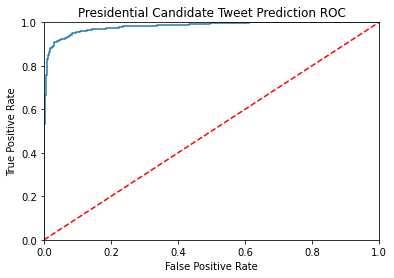

In [ ]:
# Create a list of all tweet probabilities and values
y_true = np.concatenate((np.ones(len(bidenTest)), np.zeros(len(trumpTest))))
y_scores = np.concatenate((bidenTestProbs, trumpTestProbs))

# Plot the ROC for Biden's tweets
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Presidential Candidate Tweet Prediction ROC")

AUROC = metrics.roc_auc_score(y_true, y_scores)
print("AUROC: ", AUROC)